In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.dates import AutoDateLocator, AutoDateFormatter
import matplotlib.ticker as ticker

# Analisando os dados de Óbitos no Rio de Janeiro

Vamos exemplificar algumas consultas e visualizações dos dados de óbitos da região metropolitana do Rio de Janeiro. Esses dados estão divididos em tabelas referentes aos meses de janeiro à maio. Precisaremos primeiro importá-los e, em seguida, poderemos fazer vários tipos de consulta sobre eles:

## 1. Importação e preparação dos dados

Primeiro, criamos uma lista com os caminhos dos arquivos que precisamos:

In [2]:
p = Path('.')
paths = list(p.glob('*/*.csv'))
paths

[PosixPath('maio/grande_rio_maio.csv'),
 PosixPath('abril/grande_rio_abril.csv'),
 PosixPath('fevereiro/grande_rio_fevereiro.csv'),
 PosixPath('janeiro/grande_rio_janeiro.csv'),
 PosixPath('marco/grande_rio_marco.csv'),
 PosixPath('Capitais/obitos_covid_capitais.csv')]

São apenas os cinco primeiros da lista. Excuímos o último:

In [3]:
paths = paths[:-1]
paths

[PosixPath('maio/grande_rio_maio.csv'),
 PosixPath('abril/grande_rio_abril.csv'),
 PosixPath('fevereiro/grande_rio_fevereiro.csv'),
 PosixPath('janeiro/grande_rio_janeiro.csv'),
 PosixPath('marco/grande_rio_marco.csv')]

Agora, importamos cada um deles como um Data Frame independente:

In [4]:
dataframes = [
    pd.read_csv(
        path,
        usecols=['Date', 'State', 'City', 'Age', 'Gender', 'Place of Death', 'Cause' ,'#',],
        parse_dates=[0],
        index_col=0
    )
    for path in paths
]

Vamos verificar as cinco primeiras linhas do primeiro Data Frame para ver se está tudo certo:

In [5]:
dataframes[0].head()

,State,City,Age,Gender,Place of Death,Cause,#
Date,,,,,,,
2019-05-01,RJ,Rio de Janeiro,< 9,M,HOSPITAL,OUTRAS,1
2019-05-01,RJ,Rio de Janeiro,< 9,M,HOSPITAL,PNEUMONIA,1
2019-05-01,RJ,Rio de Janeiro,10 - 19,M,HOSPITAL,OUTRAS,1
2020-05-01,RJ,Rio de Janeiro,10 - 19,M,HOSPITAL,OUTRAS,2
2019-05-01,RJ,Rio de Janeiro,20 - 29,M,HOSPITAL,SEPTICEMIA,1


Como vamos querer analisar os dados como um todo, vamos juntar todos esses Data Frames em um só e ordená-lo:

In [6]:
# Concatenando data frames
obitos_df = pd.concat(dataframes)

# Ordenando o data frame
obitos_df.sort_values(by=['Date', 'State', 'City', 'Age', 'Gender', 'Place of Death', 'Cause'], axis=0, inplace=True)

In [7]:
obitos_df.head()

,State,City,Age,Gender,Place of Death,Cause,#
Date,,,,,,,
2019-01-01,RJ,Belford Roxo,30 - 39,F,HOSPITAL,INSUFICIENCIA_RESPIRATORIA,1
2019-01-01,RJ,Belford Roxo,60 - 69,M,HOSPITAL,SEPTICEMIA,1
2019-01-01,RJ,Belford Roxo,80 - 89,F,HOSPITAL,OUTRAS,1
2019-01-01,RJ,Belford Roxo,90 - 99,F,DOMICILIO,OUTRAS,1
2019-01-01,RJ,Duque de Caxias,20 - 29,M,VIA_PUBLICA,OUTRAS,1


In [8]:
obitos_df.tail()

,State,City,Age,Gender,Place of Death,Cause,#
Date,,,,,,,
2020-05-31,RJ,São Gonçalo,60 - 69,M,HOSPITAL,COVID,1
2020-05-31,RJ,São Gonçalo,60 - 69,M,HOSPITAL,PNEUMONIA,1
2020-05-31,RJ,São Gonçalo,70 - 79,F,HOSPITAL,OUTRAS,2
2020-05-31,RJ,São Gonçalo,70 - 79,F,OUTROS,OUTRAS,1
2020-05-31,RJ,Tanguá,70 - 79,F,DOMICILIO,OUTRAS,1


## 2. Análise de Dados

Tendo todos os nossos dados de interesse em uma estrutura conveniente como um data frame, podemos realizar uma uma ampla gama de sumarizações e visualizações, usando as funcionalidades providas pelas bibliotecas ```pandas``` e ```matplotlib```. É interessante notar que, apesar de termos de usar comandos diferentes para produzir cada visualização, a lógica subjacente é sempre a mesma e recebe o nome de [Split-Apply-Combine Strategy](http://vita.had.co.nz/papers/plyr.pdf).

### 2.1 Comparando óbitos entre 2019 e 2020

Uma primeira pergunta básica que podemos fazer é: qual o total de óbitos registrados?

In [9]:
obitos_by_year = obitos_df.groupby([obitos_df.index.year]).sum()
obitos_by_year

,#
Date,
2019,39101
2020,46815


O que fizemos aqui foi agrupar os óbitos registrados por seus respectivos anos e, em seguida, somar os óbitos em seus grupos. 

É fácil agora plotar esse resultado:

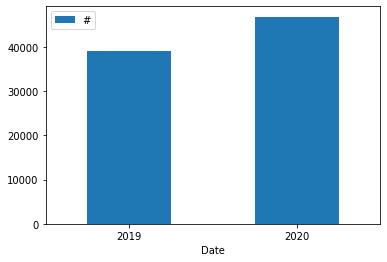

In [10]:
obitos_by_year.plot.bar(rot=0);

Poderíamos ter também plotado a transposta desse data frame, que produz um resultado mais bonito:

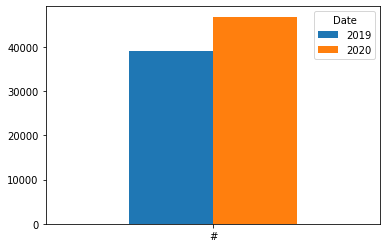

In [11]:
obitos_by_year.T.plot.bar(rot=0);

## 2.2. Estratificando por causa

Se quiséssemos continuar comparando os dois anos, mas estratificar os óbitos em função da causa declarada?

In [12]:
obitos_by_year_cause = obitos_df.groupby([obitos_df.index.year, obitos_df.Cause]).sum()
obitos_by_year_cause

#
Date Cause                            
2019 INDETERMINADA                  12
     INSUFICIENCIA_RESPIRATORIA   2534
     OUTRAS                      22179
     PNEUMONIA                    6955
     SEPTICEMIA                   7389
     SRAG                           32
2020 COVID                        7023
     INDETERMINADA                 694
     INSUFICIENCIA_RESPIRATORIA   2988
     OUTRAS                      21960
     PNEUMONIA                    7094
     SEPTICEMIA                   6230
     SRAG                          826

Para que possamos plotar esse resultado de forma conveniente, temos que fazer algumas transformações no data frame. Primeiro, transformar as causas em colunas:

In [13]:
obitos_by_year_cause = obitos_by_year_cause.unstack(fill_value=0) # Fill_value=0 faz com que o dado faltante de covid em 2019 seja preenchido com zero
obitos_by_year_cause.columns = obitos_by_year_cause.columns.droplevel() # Simplificando a rotulação das colunas
obitos_by_year_cause

Cause,COVID,INDETERMINADA,INSUFICIENCIA_RESPIRATORIA,OUTRAS,PNEUMONIA,SEPTICEMIA,SRAG
Date,,,,,,,
2019,0,12,2534,22179,6955,7389,32
2020,7023,694,2988,21960,7094,6230,826


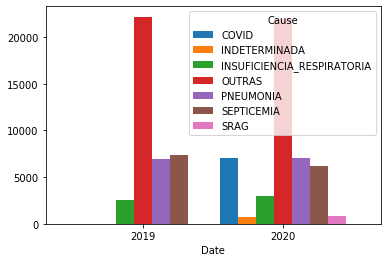

In [14]:
obitos_by_year_cause.plot.bar(rot=0, width=.9);

Esse gráfico torna extremamente evidente que o número oficial de óbitos por COVID19 subestima o excedente de mortos provavelmente acarretados pela pandemia.

Desse resultado também podemos plotar apenas certas causas:

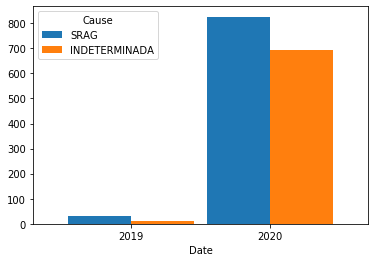

In [15]:
obitos_by_year_cause.plot.bar(rot=0, width=.9, y=['SRAG', 'INDETERMINADA']);

Esse gráfico escancara ainda mais que casos de COVID quase que certamente estão sendo erroneamente classificados.

Podemos também plotar o primeiro gráfico excetuando a causa 'OUTRAS', que dificulta a visualização das demais:

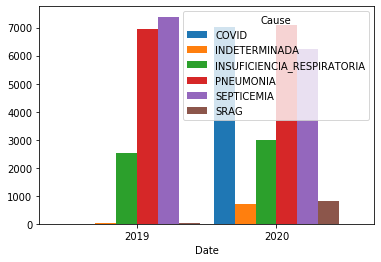

In [16]:
obitos_by_year_cause.plot.bar(rot=0, width=.9, y=obitos_by_year_cause.columns.difference(['OUTRAS']));

## 2.3. Por local de óbito

Vamos agora observar como a taxa de óbitos mudou entre os dois anos relativo aos locais de óbito. O procedimento é similar ao realizado na última análise:

In [17]:
obitos_by_year_place = obitos_df.groupby([obitos_df.index.year, obitos_df['Place of Death']]).sum()
obitos_by_year_place

#
Date Place of Death       
2019 DOMICILIO        5152
     HOSPITAL        33079
     OUTROS            744
     VIA_PUBLICA       126
2020 DOMICILIO        6772
     HOSPITAL        39066
     OUTROS            758
     VIA_PUBLICA       219

In [18]:
obitos_by_year_place = obitos_by_year_place.unstack(fill_value=0)
obitos_by_year_place.columns = obitos_by_year_place.columns.droplevel()
obitos_by_year_place

Place of Death,DOMICILIO,HOSPITAL,OUTROS,VIA_PUBLICA
Date,,,,
2019,5152,33079,744,126
2020,6772,39066,758,219


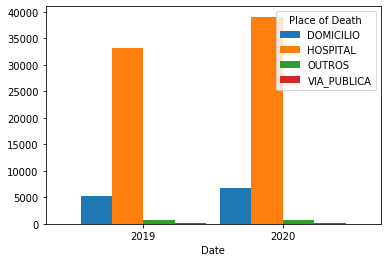

In [19]:
obitos_by_year_place.plot.bar(rot=0, width=.9);

Como número de óbitos em hospitais é significativamente maior que todos os outros locais, vamos omití-lo para melhor visualizá-los:

In [20]:
y=obitos_by_year_cause.columns.difference(['OUTRAS'])

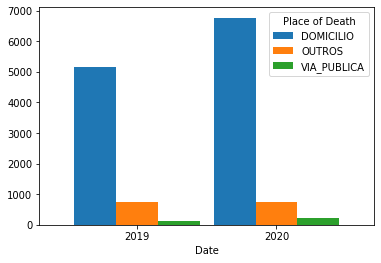

In [21]:
obitos_by_year_place.plot.bar(rot=0, width=.9, y=obitos_by_year_place.columns.difference(['HOSPITAL']));

O excesso de óbitos domiciliares não é desprezível. Possivelmente evidência uma dificuldade de acesso a cuidados médicos encarados por uma parcela das vítimas da pandêmia

## 2.4. Analisando os dados diariamente

Até agora, avaliamos os dados sumarizados por seus respectivos anos. Isso, no entanto, não nos permite compreender o impacto da dinâmica de propagação do vírus. Para tal, precisamos usar uma unidade mais granular de tempo.

### 2.4.1. Indiscriminando causa e local

Primeiro, criamos uma função auxiliar para criar os dados sumarizados dia a dia:

In [22]:
def df_by_day(df, groupby=[]):
    temps = []
    for year in ['2019', '2020']:
        temp = df[year].reset_index()
        temp['date_str'] = list(map(lambda t: '{:02d}-{:02d}'.format(*t), zip(temp['Date'].dt.month, temp['Date'].dt.day)))
        temp = temp.groupby([temp.Date.dt.year, temp.date_str, *groupby]).sum().unstack([0]+[2+i for i in range(len(groupby))], fill_value=0)
        temp.columns = temp.columns.droplevel()
        temps.append(temp)
        
    return pd.concat(temps, axis=1).sort_index().fillna(0)

In [25]:
by_day = df_by_day(obitos_df)
by_day

Date,2019,2020
01-01,240.0,297
01-02,229.0,238
01-03,262.0,220
01-04,296.0,219
01-05,239.0,232
...,...,...
05-27,322.0,363
05-28,303.0,318
05-29,295.0,291
05-30,288.0,234


Plotando o valor cumulativo de óbitos ao longo do tempo:

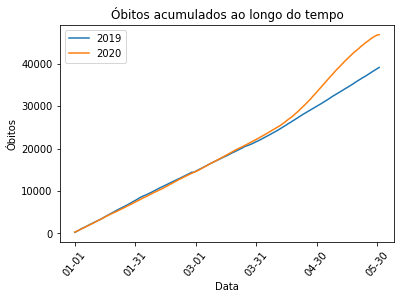

In [26]:
fig, ax = plt.subplots()

ax.plot(by_day.index, by_day[2019].cumsum(), label='2019')
ax.plot(by_day.index, by_day[2020].cumsum(), label='2020')

loc = ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax.legend()

ax.set_xlabel('Data')
ax.set_ylabel('Óbitos')
ax.set_title('Óbitos acumulados ao longo do tempo')

plt.xticks(rotation=50)

plt.show()

É interessante notar que o descolamento das curvas só acontece a partir de meados de abril.

### 2.4.2. Destacando causas

Vamos um gráfico similar ao anterior, mas destacando causas, individuais ou em grupos. Primeiro, coletamos os dados diários discriminando as causas.

In [27]:
by_cause = df_by_day(obitos_df, groupby=['Cause'])
by_cause

Date                        2019                                   \
Cause INSUFICIENCIA_RESPIRATORIA OUTRAS PNEUMONIA SEPTICEMIA SRAG   
01-01                       14.0  129.0      51.0       44.0  2.0   
01-02                       11.0  151.0      28.0       39.0  0.0   
01-03                       13.0  148.0      45.0       54.0  2.0   
01-04                       18.0  180.0      41.0       56.0  0.0   
01-05                       17.0  126.0      37.0       58.0  0.0   
...                          ...    ...       ...        ...  ...   
05-27                       22.0  181.0      67.0       51.0  1.0   
05-28                       17.0  167.0      65.0       54.0  0.0   
05-29                       18.0  164.0      56.0       56.0  1.0   
05-30                       19.0  165.0      54.0       49.0  1.0   
05-31                       18.0  169.0      62.0       53.0  0.0   

Date                         2020                                              \
Cause INDETERMINADA INDETERMINADA INSUFICIENCIA_RESPIRATORIA OUTRAS PNEUMONIA   
01-01           0.0             4                         27    160        54   
01-02           0.0             4                         15    137        42   
01-03           0.0             3                         13    123        46   
01-04           1.0             7                         10    114        43   
01-05           1.0             3                         13    130        44   
...             ...           ...                        ...    ...       ...   
05-27           0.0             5                         18    147        35   
05-28           0.0             3                         17    128        31   
05-29           0.0             4                         10    106        28   
05-30           0.0             3                         11     92        37   
05-31           0.0             0                          2     46         6   

Date                         
Cause SEPTICEMIA SRAG COVID  
01-01         52    0     0  
01-02         39    1     0  
01-03         35    0     0  
01-04         45    0     0  
01-05         42    0     0  
...          ...  ...   ...  
05-27         31   14   113  
05-28         24    6   109  
05-29         25    9   109  
05-30         16    4    71  
05-31          4    1    21  

[152 rows x 13 columns]

Vamos traçar três curvas: óbitos por todas as causas em 2019, óbitos por todas as causas em 2020 e óbitos acarretados por COVID19 em 2020:

In [28]:
all_2019 = by_cause[2019].sum(axis=1)
all_2020 = by_cause[2020].sum(axis=1)
covid_2020 = by_cause[2020][['COVID']]

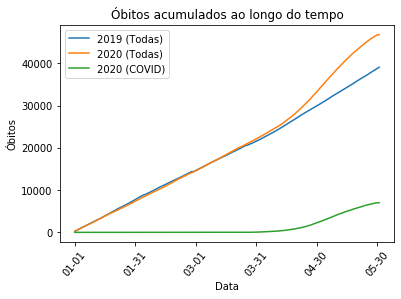

In [29]:
fig, ax = plt.subplots()

ax.plot(by_cause.index, all_2019.cumsum(), label='2019 (Todas)')
ax.plot(by_cause.index, all_2020.cumsum(), label='2020 (Todas)')
ax.plot(by_cause.index, covid_2020.cumsum(), label='2020 (COVID)')

loc = ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax.legend()

ax.set_xlabel('Data')
ax.set_ylabel('Óbitos')
ax.set_title('Óbitos acumulados ao longo do tempo')

plt.xticks(rotation=50)

plt.show()

Podemos ver aqui que os óbitos por COVID19 em grande parte justificam o excesso de óbitos em 2020.

# Função genérica de plotagem de óbitos por grupo ao longo do tempo

Podemos generalizar a ideia dos últimos gráficos em um função que nos permite traçar curvas de óbitos especificadas a partir das causas (ou local de óbito, como veremos adiante). A função toma como argumento principal um dicionário com formato:

```
{
    2019: {
        <nome_curva>: [<causas>]
    },
    2020: {
        <nome_curva>: [<causas>]
    }
}
```

In [30]:
def plot_by_group(dataframe, curves, group='Cause', cumulative=True, title=None, max_ticks=10, xlabel='Data', ylabel='Óbitos'):
    if group != 'Cause' and group != 'Place of Death':
        raise ValueError("Group argument must be either 'Cause' or 'Place of Death'!")
    
    by_group = df_by_day(dataframe, groupby=[group])
    
    fig, ax = plt.subplots()
    
    for year, cs in curves.items():
        df = by_group[int(year)]
        
        for label, c in cs.items():
            if c == 'all':
                c = df.columns
            
            # Summarize deaths by the specified causes
            series = df[c].sum(axis=1)
                
            if cumulative:
                series = series.cumsum()
                
            ax.plot(by_group.index, series, label=label)

    loc = ax.xaxis.set_major_locator(ticker.MaxNLocator(max_ticks))
    ax.legend()

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if title:
        ax.set_title(title)
    elif cumulative:
        ax.set_title('Óbitos acumulados ao longo do tempo')
    else:
        ax.set_title('Óbitos registrados ao longo do tempo')

    plt.xticks(rotation=50)

    # plt.show()
    return fig

Agora, podemos reproduzir o último gráfico:

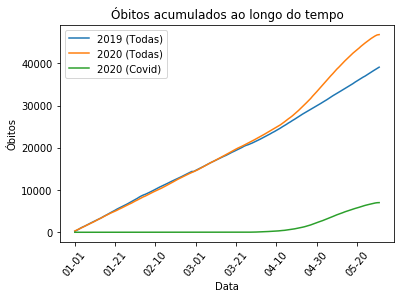

In [31]:
fig = plot_by_group(obitos_df, curves={
    2019: {
        '2019 (Todas)': 'all'
    },
    2020: {
       '2020 (Todas)': 'all',
        '2020 (Covid)': ['COVID']
    }
})

A função retorna a figura para que possamos salvá-la como uma imagem:

In [32]:
fig.savefig('fig.png')

Note que se não atribuírmos o retorno da função ou se não terminarmos sua chamada com um ponto e vírgula, o notebook acaba a exibindo duas vezes.

Podemos usar a função para traçar diferentes curvas. Vamos comparar obítos registrados como 'SRAG' nos dois anos:

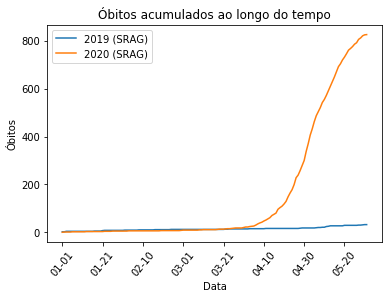

In [33]:
fig = plot_by_group(obitos_df, curves={
    2019: {
        '2019 (SRAG)': ['SRAG']
    },
    2020: {
        '2020 (SRAG)': ['SRAG']
    }
})

### 2.4.3. Destacando local de óbito

A função definida na última seção também nos permite descriminar por local de óbito:

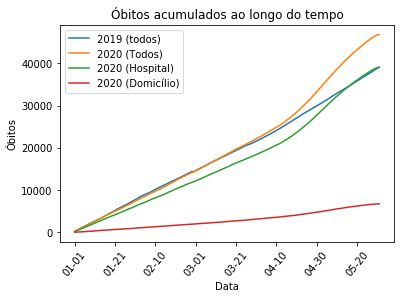

In [34]:
plot_by_group(obitos_df, curves={
    2019: {
        '2019 (todos)': 'all'
    },
    2020: {
        '2020 (Todos)': 'all',
        '2020 (Hospital)': ['HOSPITAL'],
        '2020 (Domicílio)': ['DOMICILIO']
    }
}, group='Place of Death');

Aqui podemos ver que o crescimento do número de mortes em hospitais, seguindo de forma bem mais discrita do crescimento do número de óbidos em domicílio, respondem em grande parte o excesso de mortes no em 2020.